# Session 4: Policy-gradient Pong

## Setups

In [84]:
# #uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls
# !pip install gym[atari] #For full installations, see https://github.com/openai/gym#installation
# !pip install numpy torchvision_nightly
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# import torch
# torch.__version__

## Imports

In [1]:
%matplotlib inline

#environments
import gym
from solutions.environments import Gridworld

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical
#use cuda 0 if available; assuming 1 gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#misc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

MODEL_PATH = 'models/'

## Recap: Reinforcement Learning with Discrete States and Actions

Environments we have solved so far:
* Gridworld
* Blackjack-v0
* Taxi-v2

**Coding Assignment** What do they have in common? Find out what are the states and actions of each environment above.

In [8]:
#create environments
gridworld_env = Gridworld()
bj_env = gym.make('Blackjack-v0')
taxi_env = gym.make('Taxi-v2')

'''
Write your code here
'''

gridworld_env.state_space, bj_env.observation_space, taxi_env.observation_space

([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)],
 Tuple(Discrete(32), Discrete(11), Discrete(2)),
 Discrete(500))

**Hints** 
* `env.reset()` returns the initial state of an environment.
* `env.action_space` returns the action space of the environment.
* `env.observation_space` or `env.state_space` returns the state space of the environment.

## What Got You Here Will Not Take You There

So far our methods of finding the optimal policy has been:

1. Predict the action values given a state using either **a sample of transitions (Monte Carlo)** or **previous action values (Temporal Difference)**.
2. Store those values in a dictionary `Q[state][action]`
3. To perform an optimal action, choose the action index which gives the highest action value in the dictionary.

But what if we have infinitely many states?

## [Pong-v0](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py)

One of the most influential articles on deep reinforcement is Andrej Karpathy's [Deep Reinforcement Learning: Pong from Pixels](https://karpathy.github.io/2016/05/31/rl/), where he details how to train an agent that learns to play Atari Pong from raw pixels using a technique called **policy gradient**. This session will borrow heavily from this article as well as [a lecture by David Silver](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf).

If you are too young to be familiar with Pong, try it [here](http://www.pongonline.net/).

In [87]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/YOW8m2YGtRg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Coding Assignment** Before we dive in, let us do some warm-up exercises of finding out more about `PongDeterministic-v0`

* State space
* Action space
* Rewards
* How many episodes on average with random actions
* Render one frame and see how it looks like

In [36]:
#create environment
env = gym.make('Pong-v0')
env.reset()
print(f'Each action index means: {env.unwrapped.get_action_meanings()}')

'''
Write your code here
'''


Each action index means: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


## Monte Carlo Policy Gradient aka Vanilla Policy Gradient aka REINFORCE aka Stochastic Policy Gradient

The gist of it is that instead of using the three steps we have done so far, we do:

1. Get rid of the Q dictionary altogether.
2. Use a neural network called **policy network** that takes the input of state (pixels) and outputs which action to take as our policy.
3. Get **a sample of transitions and discounted rewards** based on that neural network.
4. Optimize the policy network to maximize the **expected discounted rewards** using **gradient ascent**.

<img src="img/pong_pg.png" alt="Pong Policy Gradient"/>

### Preprocess Input

Instead of taking the entire height (210) * width (160) * color channels (3) = 100,800 pixels for input, we prepocess to a black-and-white 80 * 80 image.

(210, 160, 3)


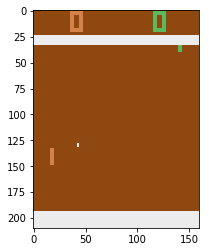

In [46]:
env.reset()
for i in range(50): 
    action = np.random.choice([2,3])
    state, reward, done, info = env.step(action)
pre_img = state
print(pre_img.shape)
plt.imshow(pre_img)

In [47]:
#adapted from https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
def preprocess_state(I):
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    res = I.astype(np.float).reshape(-1)
    return(res)

(6400,)


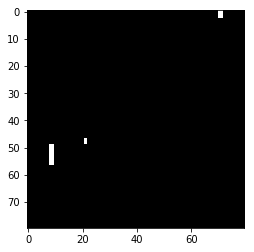

In [48]:
post_img = preprocess_state(pre_img)
print(post_img.shape)
plt.imshow(post_img.reshape(80,80), 'gray')

### Policy Network

We use a policy network that takes an input of state and output the probability of taking an action directly. That is, we are not estimating the action value function $Q(s,a)$ but directly the policy function $\pi(a|s)$.

In [96]:
class PolicyNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),1)
        return(x)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        #get probability
        probs = self.forward(state).cpu()
        #create a discrete distribution based on our probability
        m = Categorical(probs)
        #sample action
        action = m.sample()
        return(action.item(), m.log_prob(action))
    
#initiate random policy
policy = PolicyNet(6400,1000,2)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [80]:
env = gym.make('Pong-v0')
state = env.reset()
x = preprocess_state(state)
x.shape

(6400,)

In [81]:
#policy
action_idx,log_prob = policy.act(x)
action_idx, log_prob

(0, tensor([-0.7062], grad_fn=<SqueezeBackward1>))

**Coding Assignment** Use the randomly initiated policy network to play the game for 30 episodes. 
* What is the average reward across all episodes?
* How many times the agent chose to go left or right?

Note that in line with [Karpathy's implementation](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5), we will be using the difference of frames as our state.

-21.0
Counter({1: 15765, 0: 14833})


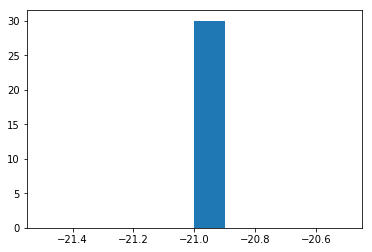

In [99]:
scores = []
actions = []
ts = []

for i in range(30):
    #initial state
    state = preprocess_state(env.reset())
    previous_state = None
    
    score = 0
    t = 0
    while True:
        t+=1
        #get input state as difference between two states
        current_state = state
        input_state = current_state - previous_state if previous_state is not None else np.zeros(80*80)
        previous_state = current_state

        '''
        Write codes to get probability and choose action here
        '''
        action = policy.act(input_state)[0]
        
        #record action
        actions.append(action)
        #environment step
        state, reward, done, info = env.step(action)
        #record score
        score+=reward
        #preprocess new state
        state = preprocess_state(state)
        if done: break
    #append scores
    scores.append(score)
    ts.append(t)
    
plt.hist(scores)
print(np.mean(scores))
print(Counter(actions))

(array([2., 1., 6., 2., 8., 2., 3., 3., 2., 1.]),
 array([1006. , 1008.9, 1011.8, 1014.7, 1017.6, 1020.5, 1023.4, 1026.3,
        1029.2, 1032.1, 1035. ]),
 <a list of 10 Patch objects>)

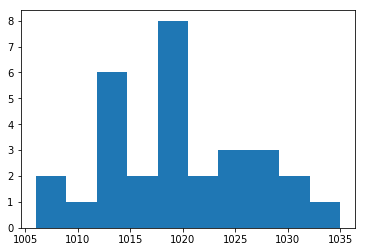

In [104]:
plt.hist(ts)

### Trajectories

With Monte Carlo methods, we collect all state-action pairs in an episode then update the Q dictionary once the episode ends. It is not very efficient since we always have to wait for the end of the episode. Here instead we will come up with an arbitrary number of timesteps and treat it as though it is an episode, calling it **trajectory** without having to wait for the `done` flag.

In [106]:
#for a single episode
def get_trajectory(policy, env, t_max=300, preprocess=True, diff_state=True, action_list=[2,3]):
    trajectories = []

    #initialize state
    if preprocess:
        state = preprocess_state(env.reset())
    else:
        state = env.reset()
    previous_state = np.zeros_like(state)

    #each trajectory
    states= []
    action_idxs = []
    rewards = []
    logprobs = []

    for t in range(t_max):
        #get input state as difference between two states
        current_state = state
        input_state = current_state - previous_state if diff_state else current_state
        previous_state = current_state

        #get action and log prob
        action_idx,log_prob = policy.act(input_state)
        action = action_list[action_idx]

        #environment step
        state, reward, done, info = env.step(action)

        #append trajectories
        logprobs.append(log_prob)
        states.append(input_state)
        action_idxs.append(action_idx)
        rewards.append(reward)

        #preprocess next state
        if preprocess: state = preprocess_state(state)

        #break if done
        if done: break
                
    trajectory = (torch.cat(logprobs), states, action_idxs, rewards)
    return(trajectory)

In [119]:
trajectory = get_trajectory(policy, env, t_max=5)
len(trajectory)

4

In [120]:
#see what's in the trajectory: logprobs, states, action_idxs, rewards
trajectory[3]

[0.0, 0.0, 0.0, 0.0, 0.0]

### Gradient Ascent

The last and most important step is to optimize the policy network so that given a state, it will be more likely to perform an action that would maximize the **expected discounted rewards** $U(\theta)$ also called **surrogate function**:

$$U(\theta) = \sum_{\tau} P(\tau;\theta) R(\tau) = \frac{1}{m}\sum_{i=1}^{m} \sum_{t=0}^{H}log\pi_{\theta}(a^i_t|s^i_t)R(\tau^i) = \frac{1}{m}\sum_{i=1}^{m} \sum_{t=0}^{H}log\pi_{\theta}(a^i_t|s^i_t)R(\tau^i)$$

where
* $\tau$ is a trajectory
* $\theta$ is a set of parameters for the policy network
* $P(\tau; \theta)$ is the probability of trajectory $\tau$ given parameters $\theta$
* $R(\tau)$ is the discounted rewards of trajectory $\tau$
* $i$ denotes a trajectory
* $t$ denotes a timestep within a trajectory

What we actually need to code up, 
* `get_trajectories` function to collect some trajectories with some number of timesteps, say 300 since it's about half the game.
* For each trajectory we have, find the sum of 

$$log(probability_{action}) * rewards_{discounted}$$

* `surrogate` function to estimate the surrogate function
* Perform gradient ascent treating surrogate function as our "loss" to update the policy network.

In [121]:
def surrogate(trajectory, gamma = 0.995):
    #expand trajectories
    logprobs,states,action_idxs,rewards = trajectory

    #get discounted rewards
    discounts = [gamma**i for i in range(len(rewards)+1)]
    discounted_rewards = sum([a*b for a,b in zip(discounts, rewards)])
    
    loss = -(logprobs * discounted_rewards)
    return(loss.sum())

In [122]:
trajectory = get_trajectory(policy,env,t_max=300)
L = surrogate(trajectory)
L

tensor(-461.4699, grad_fn=<SumBackward0>)

### Training

In [124]:
torch.manual_seed(0)
env = gym.make('Pong-v0')
policy = PolicyNet(6400,512,2)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [126]:
# keep track of progress
scores = []
last_hundreds = []

for e in trange(1000):
    # collect trajectories
    trajectory = get_trajectory(policy,env,t_max=300,preprocess=True,diff_state=True,action_list=[2,3])
    logprobs, states, actions, rewards = trajectory
    
    loss = surrogate(trajectory,gamma=0.995)
    
    #run optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #record score
    last_hundred = np.mean(scores[-100:]) if len(scores) > 0 else 0
    last_hundred = np.mean(scores[-100:])
    scores.append(np.sum(rewards))
    last_hundreds.append(last_hundred)
    
    #print
    if (e+1) % 100 ==0: 
        print(f'Episod {e+1}: Moving avg {last_hundred}; Surrogate {loss}')

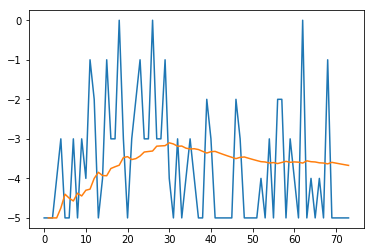

In [127]:
plt.plot(scores)
plt.plot(last_hundreds)

### Training CartPole

In [129]:
torch.manual_seed(0)
env = gym.make('CartPole-v0')
policy = PolicyNet(4,16,2)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [130]:
# keep track of progress
scores = []
last_hundreds = []

for e in range(1000):
    # collect trajectories
    trajectory = get_trajectory(policy,env,t_max=1000,preprocess=False,diff_state=False,action_list=[0,1])
    logprobs, states, actions, rewards = trajectory
    
    loss = surrogate(trajectory,gamma=1)

    #run optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #record score
    last_hundred = np.mean(scores[-100:]) if len(scores) > 0 else 0
    last_hundred = np.mean(scores[-100:])
    scores.append(np.sum(rewards))
    last_hundreds.append(last_hundred)
    
    #print
    if (e+1) % 100 ==0: 
        print(f'Episod {e+1}: Moving avg {last_hundred}; Surrogate {loss}')

Episod 100: Moving avg 22.68686868686869; Surrogate 605.4149169921875
Episod 200: Moving avg 51.08; Surrogate 2219.678955078125
Episod 300: Moving avg 63.2; Surrogate 414.86346435546875
Episod 400: Moving avg 33.13; Surrogate 716.2607421875
Episod 500: Moving avg 60.69; Surrogate 473.6524658203125
Episod 600: Moving avg 54.54; Surrogate 4044.833251953125
Episod 700: Moving avg 84.35; Surrogate 4530.611328125
Episod 800: Moving avg 75.25; Surrogate 7375.48779296875
Episod 900: Moving avg 84.67; Surrogate 2269.83935546875
Episod 1000: Moving avg 53.25; Surrogate 309.4960021972656


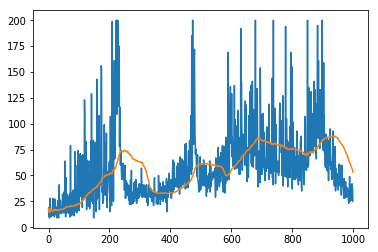

In [131]:
plt.plot(scores)
plt.plot(last_hundreds)

### Bonus: How to Derive Gradients of Policy Network

<img src="img/reinforce_derivation1.png" alt="Derivation 1"/>
<img src="img/reinforce_derivation2.png" alt="Derivation 2"/>

## Proximal Policy Optimization (PPO)

In [81]:
def surrogate_clipped(trajectory, gamma = 0.995, epsilon = 0.1):
    #expand trajectories
    logprobs,states,action_idxs,rewards = trajectory

    #get discounted rewards
    discounts = [gamma**i for i in range(len(rewards)+1)]
    discounted_rewards = sum([a*b for a,b in zip(discounts, rewards)])
    
    #clip logprobs; the only difference between REINFORCE and PPO
    logprobs_clipped = torch.clamp(logprobs, 1-epsilon, 1+epsilon)
    loss = - torch.min(logprobs*discounted_rewards, logprobs_clipped*discounted_rewards)
    return(loss.sum())

In [83]:
trajectory = get_trajectory(policy,env,t_max=300)
L = surrogate_clipped(trajectory)
L

tensor(516.6452, grad_fn=<SumBackward0>)

## Challenges

* Try training `Pong-v0` until your agent is as good as rule-based AI (score = 0) using PPO
* Try better policy networks. See `nn.Conv2d`.

## Solutions

### Pong Diagnostics

In [ ]:
env.observation_space, env.action_space

In [ ]:
action = np.random.choice([2,3])
ep_lens = []

for i in trange(30):
    env.reset()
    ep_len = 0
    while True:
        ep_len +=1
        state, reward, done, info = env.step(action)
        if done: break
    ep_lens.append(ep_len)
    
plt.hist(ep_lens)
np.mean(ep_lens)

In [ ]:
plt.imshow(state)